In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

# Get the labelled documents in the right order, and check if we are ready to stop screening

In [ ]:
# Here are the labels in the order they were created
dos = (pd.DataFrame.from_dict(DocOwnership.objects.filter(query__project=258, relevant__gt=0).order_by('id').values('id','doc_id'))
       .groupby('doc_id')
       .first()
       .sort_values('id')
       .reset_index()
       .reset_index()
       .drop(columns="id")
       .rename(columns={"doc_id":"id","index":"order"})
      )
dos.head()

In [ ]:
# Here are the unlabelled documents 
unlabelled_docs = pd.read_csv('data/0_unlabelled_documents.csv')

# And the labelled ones, in the order they were seen
df = pd.read_csv("data/0_labelled_documents.csv").merge(dos,how="left")
df.loc[~df['id'].isin(dos.id),'order'] = -1
df = df.sort_values('order').reset_index(drop=True)
df = df[pd.notna(df['relevant'])].reset_index(drop=True)
print(df.shape)

n_docs = df.shape[0] + unlabelled_docs.shape[0]

df.tail()

In [ ]:
# Here's the progress we are making so far
fig, axs = plt.subplots(1,2,figsize=(8,5))
df.relevant.cumsum().plot(ax=axs[0])
axs[0].set_xlabel("Documents seen")
axs[0].set_ylabel("Relevant documents seen")

df.relevant.rolling(window=100).mean().plot(ax=axs[1])
axs[1].set_xlabel("Documents seen")
axs[1].set_ylabel("Rolling average proportion of relevant documents")

axs[1].axhline(0.01,ls="--",lw=1,color="grey")

fig.tight_layout()

In [ ]:
# Here's how we calculate the minimum number of relevant documents in our sample consistent with the null hypothesis
import math
def get_K_hat(r_seen,tau_target,r_ML):
    return(math.floor(r_seen/tau_target - r_ML+1))

vec_get_K_hat = np.vectorize(get_K_hat)

In [ ]:
# These are the recall targets we want to assess
tau_targets = [
    {"tau_target": 0.5},
    {"tau_target": 0.66},
    {"tau_target": 0.75},
    {"tau_target": 0.9},
    {"tau_target": 0.95}
]

In [ ]:
from scipy.stats import hypergeom

for t in tau_targets:
    t['ps'] = np.zeros(df.shape[0])
    # Go through the index in steps of 50
    for i in df.index[::50]:
        docs = df.relevant.values[:i+1] # These are all the documents we consider in this step
        sample = docs[::-1] # This will be considered a random sample, that is we treat the last 1, last 2... documents as a random sample
        r_seen = docs.sum() # This is the total number of relevant docs seen at this point
        K_hat = vec_get_K_hat(
            r_seen, # The total number of documents seen
            t['tau_target'], # The recall target
            r_seen-sample.cumsum() # The 
        )
        n_sample = np.arange(1,sample.shape[0]+1) # the number of documents in the sample (an array from 1 to maximum sample length)
        p = hypergeom.cdf( # the probability of observing
            sample.cumsum(), # the number of relevant documents in the sample
            n_docs - i + n_sample, # In a population made up out of the sample and all remaining docs 
            K_hat, # Where K_hat docs in the population are actually relevant
            n_sample # After observing this many documents
        )
        t['ps'][i] = min(p)


In [ ]:
# Here's the progress we are making so far
fig, axs = plt.subplots(2,1,figsize=(8,8))
df.relevant.cumsum().plot(ax=axs[0])
axs[0].set_xlabel("Documents seen")
axs[0].set_ylabel("Relevant documents seen")

for t in tau_targets:
    t['ps'][t['ps']==0] = np.NaN
    y = t['ps'][~np.isnan(t['ps'])]
    x = np.argwhere(~np.isnan(t['ps']))
    axs[1].plot(x,y,label=t['tau_target'])
    print(f"p-score for null hypothesis that recall of {t['tau_target']} has not been achieved")
    
axs[1].legend()


In [2]:
seen_df = pd.read_csv('data/0_labelled_documents.csv')
unseen_df = pd.read_csv('data/0_unlabelled_documents.csv')
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

print(df.shape)
df.head()

(49441, 8)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen,random_sample
0,5024210,A community-based education program was conduc...,A community-based education program for serum ...,cholesterol; adult; article; blood; clinical t...,NaN,0.0,0.0,0.0
1,154716,In the light of increasing environmental probl...,Organic Agriculture - Indicator of Social Values,organic agriculture; sustainability; agricultu...,['Sociology'],0.0,1.0,NaN
2,3420290,This study investigated the emerging progressi...,FEATURES OF DESIGN OF GARDENS AND PARKS WITH S...,Kazakhstan; Symbolic Design; Numerology; Conte...,['Architecture; Environmental Studies; Urban S...,0.0,0.0,0.0
3,5011736,Use-based welfare achieves redistribution by r...,Use-Based Welfare: Property Experiments in Chi...,NaN,NaN,1.0,1.0,NaN
4,5010689,This study investigated general physicochemica...,Soil physicochemical properties in a high-qual...,Camellia sinensis; soil acidification; soil fe...,NaN,0.0,0.0,0.0


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Here we define the whole pipeline starting from creating features to training a classifier

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SVC(probability=True,  class_weight="balanced")),
])

# Now we define the parameter space we want to search. This gets computationally expensive the 
# more parameters we search, as we fit a model for every unique combination of parameters (there are fancier and smarter ways to do this)

parameters = [
    {
        'vect__max_df': (0.5,),
        'vect__min_df': (5, 10, 15),
        'vect__ngram_range': ((1, 1), (1, 2)),  
        'clf__kernel': ['rbf'], 
        'clf__gamma': [1e-3, 1e-4], # Because only the rbf kernel has the gamma parameters, we do this separately
        'clf__C': [1, 1e1, 1e2]
    },
    {
        'vect__max_df': (0.5,),
        'vect__min_df': (5, 10, 15),
        'vect__ngram_range': ((1, 1), (1, 2)),  
        'clf__kernel': ['linear'], 
        'clf__C': [1e2, 1e3]
    }
]

clf = GridSearchCV(pipeline, parameters, scoring="f1", n_jobs=4, verbose=1)

In [4]:
retrain = False
if retrain:
    # Now we fit them, by default we try a model for each set of parameters for 5 folds of train/test data
    # Even with this running in parallel (n_jobs=8) this might be time to get a coffee
    clf.fit(df.loc[seen_index, 'content'], df.loc[seen_index,'relevant'])
    # The best model is the combination of parameters with the highest mean score across 5 folds
    clf.best_estimator_
    results = pd.DataFrame(clf.cv_results_)
    results.head()
    f1_scores = [results[f"split{x}_test_score"].values[0] for x in range(5)]
    print(np.mean(f1_scores))

    fig, ax = plt.subplots()

    ax.boxplot(f1_scores)
    ax.set_ylim([0,1])
    ax.grid(axis="y")
    ax.set_xticklabels(["Best performing model"])
    ax.set_ylabel('F1 score')
else:
    # No time to retrain, we'll just take the pipeline with the best performance from last time
    clf = Pipeline(steps=[
        ('vect', TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1,2))),
        ('clf', SVC(C=100.0, class_weight='balanced', probability=True))
    ])
    clf.fit(df.loc[seen_index, 'content'], df.loc[seen_index,'relevant'])

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


71


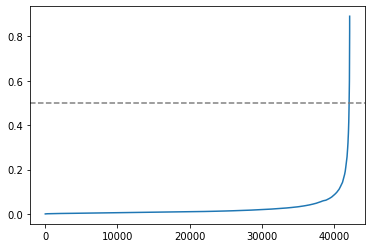

In [5]:
y_pred = clf.predict_proba(df.loc[unseen_index,'content'])

df['prediction'] = None
df['prediction'][unseen_index] = y_pred[:,1]
y_pred.shape

plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])

plt.show()

In [6]:
django.db.connection.close()
assigned = set(DocOwnership.objects.filter(query=10452).values_list('doc_id',flat=True))
q = Query.objects.get(pk=10452)
tag, created = Tag.objects.get_or_create(
    query=q,
    title="ML Prioritised 4"
)

users = list(User.objects.filter(username__in=["pradhan@pik-potsdam.de","desimone@pik-potsdam.de"]))
#users = list(User.objects.filter(username__in=["pradhan@pik-potsdam.de"]))

for i, row in df[~df['id'].isin(assigned)].sort_values('prediction',ascending=False).reset_index(drop=True).head(1500).iterrows():
    #u = users[i%2]
    u = users[0]
    do, created = DocOwnership.objects.get_or_create(
        user=u,
        doc_id=row['id'],
        query=q,
        tag=tag
    )
        
tag.update_tag()